## Introduction

The following code entails all the function and methods we used to create our final project. It is currently run on an example dataset of size 50. \
The dataset used in this project can be found under https://www.agriculture-vision.com/agriculture-vision-2021/dataset-2021 and can be downloaded via the aws cli. 

### Packages &amp; Directories

In [ ]:
!pip install pandas
!pip install sklearn
!pip install tensorflow==2.7
!pip install keras==2.7
!pip install scipy
!pip install tensorflow-addons

In [1]:
# Packages
import os
import time
import numpy as np
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import keras
from tensorflow import keras
import keras.layers as layers
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
import tensorflow_addons as tfa

In [53]:
# Different directory variables depending on stage of training/testing change to fit your environment

directory_image_train = "train/images/rgb"
directory_mask_train = "train/masks"
directory_boundaries_train = "train/boundaries"
directory_labels_train = "train/labels/"

directory_image_validation = "val/images/rgb"
directory_mask_validation = "val/masks"
directory_boundaries_validation = "val/boundaries"
directory_labels_validation = "val/labels/"

size = 50 #use to limit dataset size

### Labeling the dataset

In [54]:
def labeling_picture(directory, size): 
    '''
    Takes in a directory and a size of the data set to be labelled.
    Returns: labeled pictures
    '''
    
    # (1) 'label_list' gets the files in the inputted directory and returns a list of files in that directory.
        # So if we put the 'labels' folder as directory, it will list the 9 labels (or folders) that are in there.
    # (2) '_label' is the numerical value that we will give to the category/label 
    # (3) 'categories_df' is an empty list ...
    # (4) 'pictures' is an empty list where the pictures will be added that we loop through below.
    
    label_list = os.listdir(directory)
    _label = 0 
    categories_df = []
    pictures = []
    _break = 0

    # Looping through the labels (folder level)
    # For each label or folder in this list that we retrieved in the previous step:
    # (1) print the label
    # (2) '_picture' is the number of the picture in the sorted list
    # (3) 'category' is a list long enough to hold all picture labels to be appended to a dataframe
    # (4) 'pic_list' is a variable which returns a list of files in the folders of the label (so one level deeper) and store it in pic_list
    
    for label in sorted(label_list):

        if _break == size: 
            break
        
        pic_list = os.listdir(directory+label)
        print(label) 
        _picture = 0 
        category = [None] * size # or len(pic_list) if run on all data
        
        #looping through the pictures in the label folder
        for picture in sorted(pic_list):
            
            if _break == size: 
                break
            pictures.append(picture)
            #check if picture has two colors by checking if all pixesl are on average black(0)
            img = Image.open(directory+label+"/"+picture)
            if np.average(img) != 0: 

                #add label to category matrix   
                category[_picture] = 1
            else: 
                category[_picture] = 0 
            _picture += 1
            _break += 1

        _break = 0
        _label += 1 
        categories_df.append(category)

    # Create a dataframe with all labeled pictures 
    y = pd.DataFrame({
                "double_plant": categories_df[0],
                "drydown": categories_df[1],
                "endrow": categories_df[2],
                "nutrient_deficiency": categories_df[3],
                "planter_skip": categories_df[4],
                "storm_damage": categories_df[5],
                "water": categories_df[6],
                "waterway": categories_df[7], 
                "weed_cluster": categories_df[8], 
                 }, 
                 index = np.unique(pictures))

    return y

In [55]:
#getting the labeled data for training
y_train_full = labeling_picture(directory_labels_train, size)
#labelling the validation & test data 
y_val_and_test = labeling_picture(directory_labels_validation, size)


double_plant
drydown
endrow
nutrient_deficiency
planter_skip
storm_damage
water
waterway
weed_cluster
double_plant
drydown
endrow
nutrient_deficiency
planter_skip
storm_damage
water
waterway
weed_cluster


### Data preprocessing and cleaning

In [56]:
# This function takes the arrays of the RGB image, the boundary and the mask as input
# It returns the product of the three arrays, meaning these images will be the final input

def masking_bounding (np_image, np_bound, np_mask):
    '''
    Return the image RBG values after multiplication with boundary and mask values. 
    '''
    masked_np = np.multiply(np_image, np_bound, np_mask)
    return masked_np

In [57]:
# This function is used to filter out the distorted/invalid pictures that should not be used for input
# The function returns a list of three elements corresponding to avg RBG values respectivly. If these exceed the limits, then the image will be considered non-usable.

def filter_rbg(image_value, image_number):
    """
    Takes in the np_image variable from calc_masked_boundaries and returns average RBG values. After 
    that it checks for anomialies and returns a list of the distorted pictures. 
    """
    avg_val = np.average(image_value, axis = (1, 2)) # returns a list of three elements corresponding to avg RBG values respectivly

    upper = 250 # upper limit
    lower = 5 # lower limit
    filter_TF = False

    for val in avg_val:
        if val < lower or val > upper:
            filter_TF = True
            break


    return filter_TF, image_number

In [58]:
def calc_masked_boundaries(image_path, mask_path, boundaries_path, size):
    """
    Taking the raw pictures as input and outputting them as input format for PCA/Alexnet.
    The funciton also calls the filetering function (filter_rbg) to filter out bad pictures. 
    After that it scales the pixels values to a range between 0 and 1. 

    Returns a tuple of an array and a tensor that needs to be unpacked into two variables 
    before it can be used in either PCA or Alexnet. The array is located at position 0 and
    is used for the random forrest and the tensor is located at position 1 and is used for
    the AlexNet.

    """

    #creating a list of the images to be processed 
    image_lst = os.listdir(image_path)

    #creating a list of the images & necessary variables
    X = []
    image_num = 0 
    distorted_pics = []
    _break = 0

    #looping through the pictures
    for image in sorted(image_lst):

        if _break == size: 
            break

        image = image[:-4]

        #access the mask 
        mask_img = Image.open(mask_path+"/"+ image + ".png").convert("RGB")

        #access the boundaries 
        boundaries_img = Image.open(boundaries_path + "/" + image + ".png").convert("RGB")

        #accessing the image 
        image_img = Image.open(image_path + "/" + image +".jpg").convert("RGB")

        #numpy conversion
        np_image = np.asarray(image_img)
        np_mask = np.asarray(mask_img)
        np_boundaries = np.asarray(boundaries_img)

        #Filter picture in order to make sure that RBG values are not distorted
        filter_TF, img_index = filter_rbg(np_image, image_num)
        if filter_TF == True:
            distorted_pics.append(img_index)
            image_num += 1
            _break += 1
        else: 
            #apply mask and boundary to original image
            masked_bound_img = masking_bounding(np_image, np_boundaries, np_mask)

            #normalizing the image         
            norm_img = tf.image.resize(masked_bound_img, (277,277))

            #standardizing the image to values between 0 - 1
            norm_img = norm_img / 255

            #appending normalised picture to the array
            X.append(norm_img)
            
            #necessary variables to check if dataset size is reached and keep count of 
            _break += 1
            print(image_num)
            image_num += 1
    
    #creating the Random Forest and CNN input
    X_rf = np.array(X) # Random Forest
    X = tf.convert_to_tensor(X) # CNN
    
    return X_rf, X, distorted_pics

In [59]:
def calc_masked_boundaries_val_test(image_path, mask_path, boundaries_path, y_val_test, size):
    """
    Taking the raw pictures as input and outputting them as validation & test input format for PCA/Alexnet.
    The funciton also calls the filetering function (filter_rbg) to filter out bad pictures.
    After that it scales the pixels values to a range between 0 and 1.

    Returns a tuple of an array and a tensor that needs to be unpacked into two variables
    before it can be used in either PCA or Alexnet. The array is located at position 0 and
    is used for the random forrest and the tensor is located at position 1 and is used for
    the AlexNet.

    """

    # creating a list of the images to be processed
    image_lst = os.listdir(image_path)

    # creating a list of the images & necessary variables
    X_val = [] #holding image details of validation data
    X_test = [] #holding image details of test data
    image_num = 0 #image number 
    _break = 0 #use for limited data set if no limit then comment out
    distorted_pics = [] #list of distorted pics (indicies)
    df_y_val = pd.DataFrame() #Dataframe holding all validation data labels
    df_y_test = pd.DataFrame() #Dataframe holding all test data labels

    # looping through the pictures
    for image in sorted(image_lst):

        if _break == size:
         break

        image = image[:-4]

        # access the mask
        mask_img = Image.open(mask_path + "/" + image + ".png").convert("RGB")

        # access the boundaries
        boundaries_img = Image.open(boundaries_path + "/" + image + ".png").convert(
            "RGB"
        )

        # accessing the image
        image_img = Image.open(image_path + "/" + image + ".jpg").convert("RGB")

        # numpy conversion
        np_image = np.asarray(image_img)
        np_mask = np.asarray(mask_img)
        np_boundaries = np.asarray(boundaries_img)

        # Filter picture in order to make sure that RBG values are not distorted
        filter_TF, img_index = filter_rbg(np_image, image_num)
        if filter_TF == True:
            distorted_pics.append(img_index)
            image_num += 1
            _break += 1
        else:

            # calculating the masked and boundaries imgs for validation & test
            masked_np = np.multiply(np_image, np_mask)
            bound_masked_np = np.multiply(np_image, np_boundaries, np_mask)

            # normalizing the images for the two sets
            norm_img_test = tf.image.resize(masked_np, (277, 277))
            norm_img_val = tf.image.resize(bound_masked_np, (277, 277))

            # standardizing the image to values between 0 - 1
            norm_img_test = norm_img_test / 255
            norm_img_val = norm_img_val / 255

            # appending normalised picture to the array of validation & test data
            if image_num % 2 == 0:
                X_val.append(norm_img_val)
                entry = y_val_test.loc[image + ".png"]
                df_y_val = pd.concat([df_y_val, entry], axis=1)

            else:
                X_test.append(norm_img_test)
                entry = y_val_test.loc[image + ".png"]
                df_y_test = pd.concat([df_y_test, entry], axis=1)

            # necessary variables to check if dataset size is reached and keep count of
            _break += 1
            image_num += 1
        # print(image_num)
        mask_img.close()
        boundaries_img.close()
        image_img.close()

    # creating the Random Forest and CNN input
    X_rf_val = np.array(X_val)
    X_rf_test = np.array(X_test)
    X_val = tf.convert_to_tensor(X_val)
    X_test = tf.convert_to_tensor(X_test)

    return X_rf_val, X_rf_test, X_val, X_test, distorted_pics, df_y_val, df_y_test

In [60]:
# This cell tests the calc_masked_boundaries function.
# It unpacks the tuple (immutable list) of the three arrays and assigns them to the three variables respectively

X_rf_train, X_cnn_train, distort_pics = calc_masked_boundaries(directory_image_train,directory_mask_train, directory_boundaries_train, size)
print("Filtered pictures: ",len(distort_pics))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
34
35
37
38
39
40
41
42
45
46
47
48
49
Filtered pictures:  4


In [61]:
# This cell drops the filtered datapoints of the training set.
# It goes into the dataframe of labels for the training set and drops the distorted pictures.
# We use "inplace = True" so the data is modified in place and nothing is returned. It merely updates the dataframe. 

y_train_full.drop(y_train_full.index[distort_pics], inplace = True )

In [62]:
# This cell tests the calc_maskes_boundaries_val_train function
# It unpacks the tuple (immutable list) of the five arrays and assigns them to the five variables respectively
X_rf_val, X_rf_test, X_val, X_test, distorted_pics, df_y_val, df_y_test= calc_masked_boundaries_val_test(directory_image_validation,directory_mask_validation, directory_boundaries_validation, y_val_and_test, size)

In [63]:
print(X_cnn_train.shape)
print(y_train_full.shape)
print(X_val.shape)
y_val = df_y_val.transpose()
y_val = np.array(y_val).astype("int") 
y_val = tf.convert_to_tensor(y_val)
print(y_val.shape)
y_test = df_y_test.transpose()
y_test = np.array(y_test).astype("int") 
y_test = tf.convert_to_tensor(y_test)
print(y_test.shape) 
print(X_test.shape)

(46, 277, 277, 3)
(46, 9)
(25, 277, 277, 3)
(25, 9)
(25, 9)
(25, 277, 277, 3)


### AlexNet unmodified

In [64]:
# AlexNet model unmodified
# In order to use AlexNet we use the TensorFlow library. 
# On top of the Tensorflow libarary AlexNet uses the Keras library/API to build its architecture. 

# The basic AlexNet model is a sequential model which is appropriate for stacking layers. We create this model here. 
model = keras.Sequential()

# The basic AlexNet model has 5 convolutional layers (Conv2D) which use the relu activation function (using this function speeds up the training process).
# Filters: the number of filters used in the convolutional layers changes throughout the network. As we go deeper the number of filters is increasing, meaning it is extracting more features as we go through the network. 
# Kernel size: the kernel size also varies throughout the architecture. The kernel size decreases the deeper we go into the network, decreasing the size of the shape of the feature map. 
# Strides: the stride controls how the filter convolves around the input volume and represents how much the filter shifts. In AlexNet this decreases for 4 to 1, becoming more precise. 
# Input shape: the input shape of our images. 
# Padding: Layers 2-5 include padding to prevent the size of the feature maps from reducing drastically

# After each new layer, BatchNormalization is applied to avoid the gradient becoming too small. 

# After the first two and the last convolutional layer, a pooling layer is included to summarize the learned learned image features in the previous layer. 
# Pool size: this says something about how big the region is that the maximum will be taken from. The smaller the size, the more specific it is. 
# Strides: represents how big the area shifts with each step.

# Flatten: The five convolutional layers are followed by a flatten layer which converts all the 2d arrays that resulted from the pooled feature maps into one long linear vector. This is needed to push the input through to the fully connected layers
# Next up we have two fully connected layers which include 4096 neurons and have the relu function as the activation function. 
# Dropout: 0.5 means that in training a neuron will be connected to only half as many input neurons as it would when testing.
# The final activation function is the softmax function, which has proved to work well with multiclass classification. 
model.add(layers.Conv2D(filters=96, kernel_size=(11, 11), 
                        strides=(4, 4), activation="relu", 
                        input_shape=(277, 277, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides= (2, 2)))
model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation="relu"))
model.add(layers.Dense(4096, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation="softmax"))

In [65]:
# In this cell we configure the model with the loss functions, optimizers and the metrics.
# The standard loss function of AlexNet is the BinaryCrossentropy
# from_logits = False since we want a proabability (i.e. a value between [0,1])
# We use the Stochastic Gradient Descent as optimizer.
# The metric we use to evaluate our model is the MeanIoU

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
              optimizer=tf.optimizers.SGD(lr=0.001),
              metrics=[tf.keras.metrics.MeanIoU(num_classes=9)])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 67, 67, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 67, 67, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 33, 33, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 33, 33, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 33, 33, 256)      1024      
 chNormalization)                                                
                                                      

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [66]:
# In this cell we train our model on the training set. 
# We track how much time it takes to train
# We specify that the algorithm will work through the entire training set 50 times. 
# We specify the data on which to evaluate the loss at the end of each epoch
# We instruct it to first shuffle our entire dataset and to then make batches of size 64 --> we ise 64 training examples for each step in SGD. 

start = time.time()
model.fit(X_cnn_train,y_train_full,
          epochs=2,
          validation_data=(X_val,y_val),
          validation_freq=1, 
          shuffle = True, 
          batch_size = 64)
end = time.time()
print(end-start)

Epoch 1/2
1/1 [==============================] - 4s 4s/step - loss: 1.2024 - mean_io_u_2: 0.4444 - val_loss: 0.6958 - val_mean_io_u_2: 0.4356
Epoch 2/2
1/1 [==============================] - 3s 3s/step - loss: 0.8585 - mean_io_u_2: 0.4444 - val_loss: 0.6948 - val_mean_io_u_2: 0.4356
6.900047063827515


In [67]:
# In this cell we evaluate the performance of our model based on the predefined metrics
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 369ms/step - loss: 0.6951 - mean_io_u_2: 0.4422


[0.6950905323028564, 0.4422222077846527]

### AlexNet modified

In [68]:
# AlexNet model modified

# In this cell we re-define the AlexNet architecture. 

model_AN = keras.Sequential()

model_AN.add(layers.Conv2D(filters=96, kernel_size=(11, 11), 
                        strides=(4, 4), activation="relu", 
                        input_shape=(277, 277, 3)))
model_AN.add(layers.BatchNormalization())
model_AN.add(layers.MaxPool2D(pool_size=(3, 3), strides= (2, 2)))
model_AN.add(layers.Conv2D(filters=256, kernel_size=(5, 5), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_AN.add(layers.BatchNormalization())
model_AN.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_AN.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_AN.add(layers.BatchNormalization())
model_AN.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_AN.add(layers.BatchNormalization())
model_AN.add(layers.Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_AN.add(layers.BatchNormalization())
model_AN.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_AN.add(layers.Flatten())
model_AN.add(layers.Dense(4096, activation="relu"))
model_AN.add(layers.Dense(4096, activation="relu"))
model_AN.add(layers.Dropout(0.5))
model_AN.add(layers.Dense(9, activation="softmax"))

In [69]:
# In this cell we configure the model with the loss functions, optimizers and the metrics.
# Modification: we use the SigmoidFocalCrossEntropy loss function since it has shown to be extremely useful to deal with class imbalance
# Alpha: this is the balancing factor. We have 9 different categories and the numbers represent their respective percentage of the whole. 
# Gamma: this is the modulating factor. It is standard to take a value of 2.  
# SGD: We still use SGD, but now we introduce a learning rate in combination with nesterov accelerated learning and a decay rate. This is chosen to both optimize and generalize the process.  

#including a learning rate schedule to have a decay in learning rate
learning_rate = 0.1
epochs = 50
decay_rate = learning_rate / epochs

model_AN.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=[.1, .30, .04, .22, .04, .01,.04,.06,.19], gamma=2),
              optimizer=tf.optimizers.SGD(lr=learning_rate, nesterov = True, decay = decay_rate),
              metrics=[tf.keras.metrics.MeanIoU(num_classes=9)])
model_AN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 67, 67, 96)        34944     
                                                                 
 batch_normalization_15 (Bat  (None, 67, 67, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 33, 33, 96)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 33, 33, 256)       614656    
                                                                 
 batch_normalization_16 (Bat  (None, 33, 33, 256)      1024      
 chNormalization)                                                
                                                      

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [71]:
# In this cell we train our model on the training set. 

start = time.time()

model_AN.fit(X_cnn_train,y_train_full,
                     epochs=2,
                     validation_data=(X_val,y_val),
                     validation_freq=1, 
                     shuffle = True,
                     batch_size = 64
                     )

end = time.time() 
print(end-start)

Epoch 1/2
1/1 [==============================] - 3s 3s/step - loss: 4.1749 - mean_io_u_3: 0.7455 - val_loss: 16.8772 - val_mean_io_u_3: 0.3800
Epoch 2/2
1/1 [==============================] - 3s 3s/step - loss: 4.1749 - mean_io_u_3: 0.7455 - val_loss: 16.8772 - val_mean_io_u_3: 0.3800
5.865911960601807


In [72]:
# In this cell we evaluate the performance of our model based on the predefined metrics
model_AN.evaluate(X_test,y_test)

1/1 [==============================] - 0s 387ms/step - loss: 16.6242 - mean_io_u_3: 0.3867


[16.624202728271484, 0.3866666555404663]

### Random Forest 


In [73]:
# We will be using the random forest classifier from the sklearn package. 
# For this the input must be reshaped from a 4D shape to a 2D shape. We must therefore reshape our input and we do that below. 
# We reshape from a by (1) extracting the arrays from the shape tuple and 
# (2) multiply the dimensions of the images with each other to form form one dimension.

# nsamples = amount of images
# nx = number of x pixels (277)
# ny = number of y pixels (277)
# nrgb = number of colour streams (3)

# Changing the shape of the train set 
nsamples, nx, ny, nrgb = X_rf_train.shape
X_rf_train2 = X_rf_train.reshape((nsamples,nx*ny*nrgb))
# Changing the shape of the validation set
nsamples, nx, ny, nrgb = X_rf_val.shape
X_rf_val2 = X_rf_val.reshape((nsamples,nx*ny*nrgb))
# Changing the shape of the test set
nsamples, nx, ny, nrgb = X_rf_test.shape
X_rf_test2 = X_rf_test.reshape((nsamples,nx*ny*nrgb))


96.72356

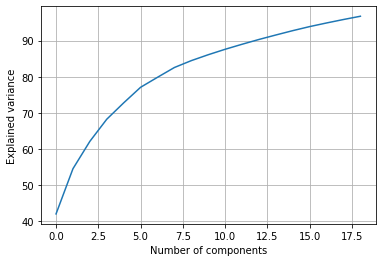

In [78]:
# In this cell we perform PCA to reduce dimensionality and increase the speed of the runs

pca = PCA(n_components=19) #if size is used then n_components must be adjusted
X_train_pca = pca.fit_transform(X_rf_train2)
X_val_pca = pca.fit_transform(X_rf_val2)
X_test_pca = pca.fit_transform(X_rf_test2)

# Make the scree plot to see how well PCA captures the variance of the data. It is a plot of how much variance is explained.
# Look for where the drop is, or where it does not improve much more. 
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png')

# See how much variance is explained with the amount of components
np.cumsum(pca.explained_variance_ratio_ * 100)[-1]

In [80]:
# We also need to change the shape of the y_val. It is not possible to transform a dataframe in a tensor, so this is a workaround

print(y_train_full.shape)
print(X_rf_test.shape)
print(y_test.shape)
print(X_test_pca.shape)
print(y_val.shape)

(46, 9)
(25, 277, 277, 3)
(25, 9)
(25, 19)
(25, 9)


In [81]:
# Initialise a random forest classifyer
rfc = RandomForestClassifier(bootstrap=True,
                              random_state=1)

In [82]:
# Specify parameters and distributions to sample from

# max_depth: The maximum depth of the tree. It will take a random integer between 1 and 300.
# max_features: The number of features to consider when looking for the best split. It will take a random integer between 1 and 11.
# min_samples_split: The minimum number of samples required to split an internal node. It will take a random integer between 1 and 11.
# min_samples_leaf: The minimum number of samples required to be at a leaf node. It will take a random integer between 1 and 11.
# bootstrap: Whether bootstrap samples are used when building trees. Will it randomly choose now?
# criterion: The function to measure the impurity of the split. “gini” for the Gini impurity and “entropy” for the Shannon information gain

param_dist = {"max_depth": sp_randint(1, 300), 
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [83]:
# In this cell we perform a random search for the best values of the hyperparameters.

# The input of the randomized search is the Random Forest Classifier.
# param_distributions: takes a dictionary of parameter names that it needs to try. We want it to do it for the parameters we specified in the cell above.
# n_iter: Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution. We chose it randomly ?? What happens if we increase/decrease it?

random_search_clf = RandomizedSearchCV(rfc, param_distributions=param_dist,
                                   n_iter=20)

In [84]:
start = time.time()

# Fit the model with the best hyperparameters to our training data
random_search_clf.fit(X_train_pca, y_train_full)

end = time.time() 

# Print how much time it takes
print(end-start)

12.266495943069458


In [85]:
#returning the best parameters
random_search_clf.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 142,
 'max_features': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 6}

In [86]:
# Checking if the shapes are similar
print(X_test_pca.shape)
print(y_test.shape)

(25, 19)
(25, 9)


In [87]:
# Print accuracy of the random forest classifier
# We will not look at this metric
preds = random_search_clf.predict(X_test_pca)
print("Accuracy of the Random Forest: ", accuracy_score(y_test, preds))

# Print the mean IoU metric
# We will use this one
metric = tf.keras.metrics.MeanIoU(num_classes=9)
metric.update_state(y_test, preds)
metric.result().numpy

Accuracy of the Random Forest:  0.0


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.39333335>>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=53d0d428-af3f-4841-98f7-12269979931d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>